<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/KAN_vs_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pykan

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from kan import KAN, create_dataset
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Create dataset

In [3]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2).float()
dataset = create_dataset(f, n_var=2)
dataset['train_input'] = dataset['train_input'].float()
dataset['train_label'] = dataset['train_label'].float()

## Create metrics

In [4]:
def mse(y_true, y_pred):
    return ((y_pred - y_true) ** 2).mean()

def rmse(y_true, y_pred):
    return torch.sqrt(mse(y_true, y_pred))


def evaluate_model(model, dataset):
    with torch.no_grad():
        outputs = model(dataset['test_input'])
        mse_value = mse(dataset['test_label'], outputs).item()
        rmse_value = rmse(dataset['test_label'], outputs).item()
    return mse_value, rmse_value

In [5]:
def train_mlp(model, optimizer, epochs=20, dataset=dataset):
    criterion = nn.MSELoss()
    mse_history = []
    rmse_history = []

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            outputs = model(dataset['train_input'])
            loss = criterion(outputs, dataset['train_label'])
            loss.backward()
            return loss

        optimizer.step(closure)
        with torch.no_grad():
            outputs = model(dataset['train_input'])
            current_mse = mse(dataset['train_label'], outputs)
            current_rmse = rmse(dataset['train_label'], outputs)

        mse_history.append(current_mse.item())
        rmse_history.append(current_rmse.item())

    return mse_history, rmse_history, model


## Create KAN model

train loss: 1.54e-01 | test loss: 1.34e-01 | reg: 2.02e+01 : 100%|██| 20/20 [00:22<00:00,  1.12s/it]


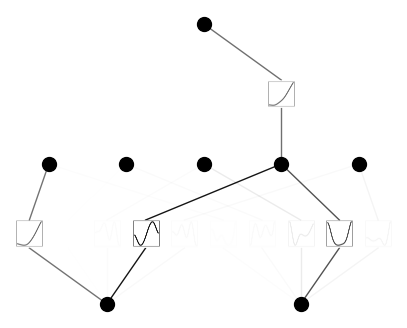

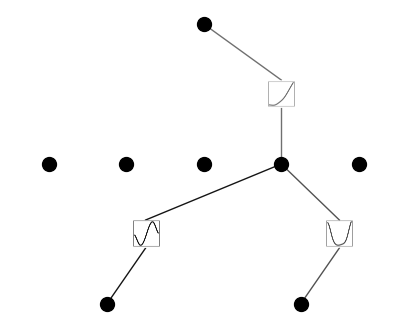

In [6]:
kan_model = KAN(width=[2, 5, 1], grid=5, k=3, seed=0)
kan_optimizer = optim.LBFGS(kan_model.parameters(), lr=1)
kan_model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)
kan_model.plot()
kan_model.prune()
kan_model.plot(mask=True)

## Create MLP

Let's train 3 MLPs and train them for 20, 200 and 2k epochs

In [15]:
mlp_models = []

epochs_list = [20, 200, 2000, 4000]
for epochs in epochs_list:
    mlp_model = nn.Sequential(
                              nn.Linear(2, 5),
                              nn.ReLU(),
                              nn.Linear(5, 5),
                              nn.ReLU(),
                              nn.Linear(5, 1))
    for param in mlp_model.parameters():
        param.data = param.data.float()
    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

    progress_bar = tqdm(range(epochs), desc=f'Training MLP Model (epochs={epochs})')
    for epoch in progress_bar:
        mse_hist, rmse_hist, mlp_model = train_mlp(mlp_model, mlp_optimizer, epochs=1)
        progress_bar.set_postfix({'RMSE': rmse_hist[-1]})

    mlp_models.append(mlp_model)


Training MLP Model (epochs=4000): 100%|██████████| 4000/4000 [00:20<00:00, 196.36it/s, RMSE=0.219]


## Plot predictions

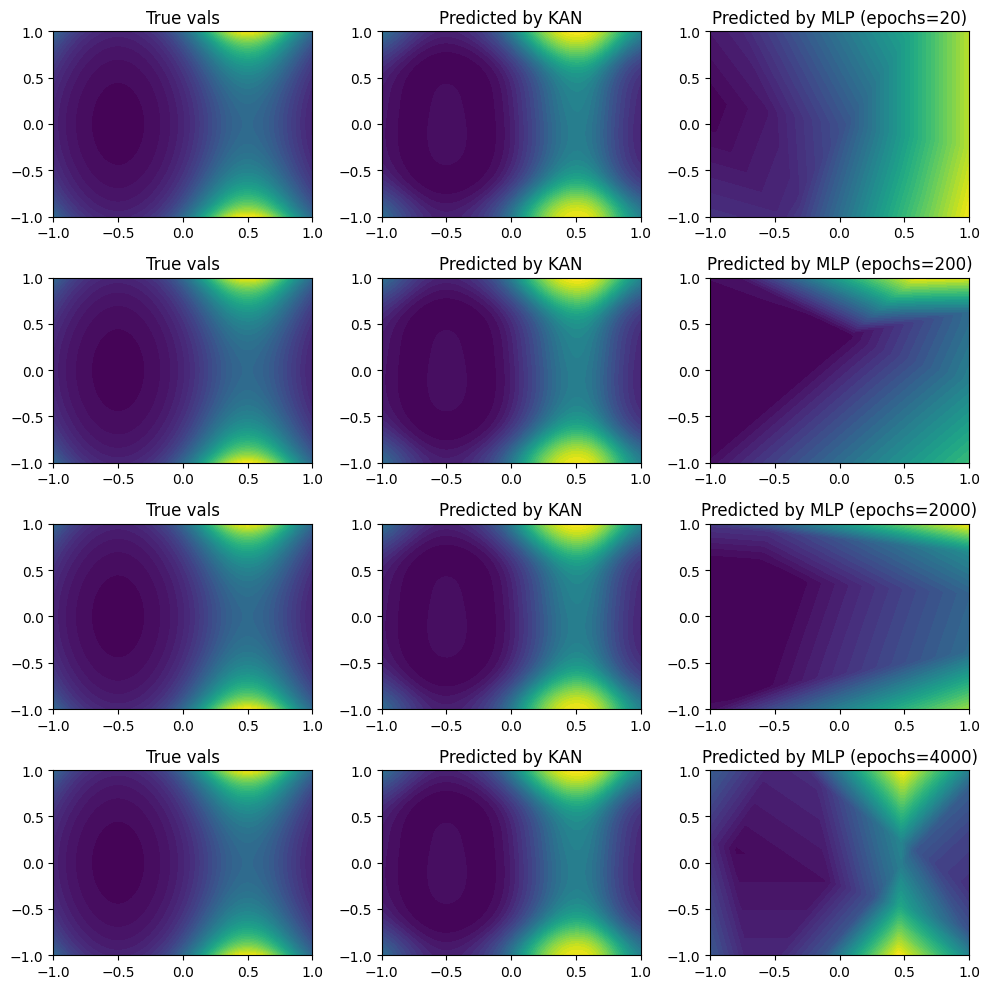

In [16]:
fig, axs = plt.subplots(len(epochs_list), 3, figsize=(10, 2*(len(epochs_list) + 1)))

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

true_values = f(xy).reshape(100, 100).numpy()

with torch.no_grad():
    kan_predictions = kan_model(xy).reshape(100, 100).numpy()
    for i, mlp_model in enumerate(mlp_models):
        mlp_predictions = mlp_model(xy).reshape(100, 100).numpy()
        axs[i, 0].contourf(X, Y, true_values, levels=50, cmap='viridis')
        axs[i, 0].set_title('True vals')
        axs[i, 1].contourf(X, Y, kan_predictions, levels=50, cmap='viridis')
        axs[i, 1].set_title('Predicted by KAN')
        axs[i, 2].contourf(X, Y, mlp_predictions, levels=50, cmap='viridis')
        axs[i, 2].set_title(f'Predicted by MLP (epochs={epochs_list[i]})')

plt.tight_layout()
plt.show()

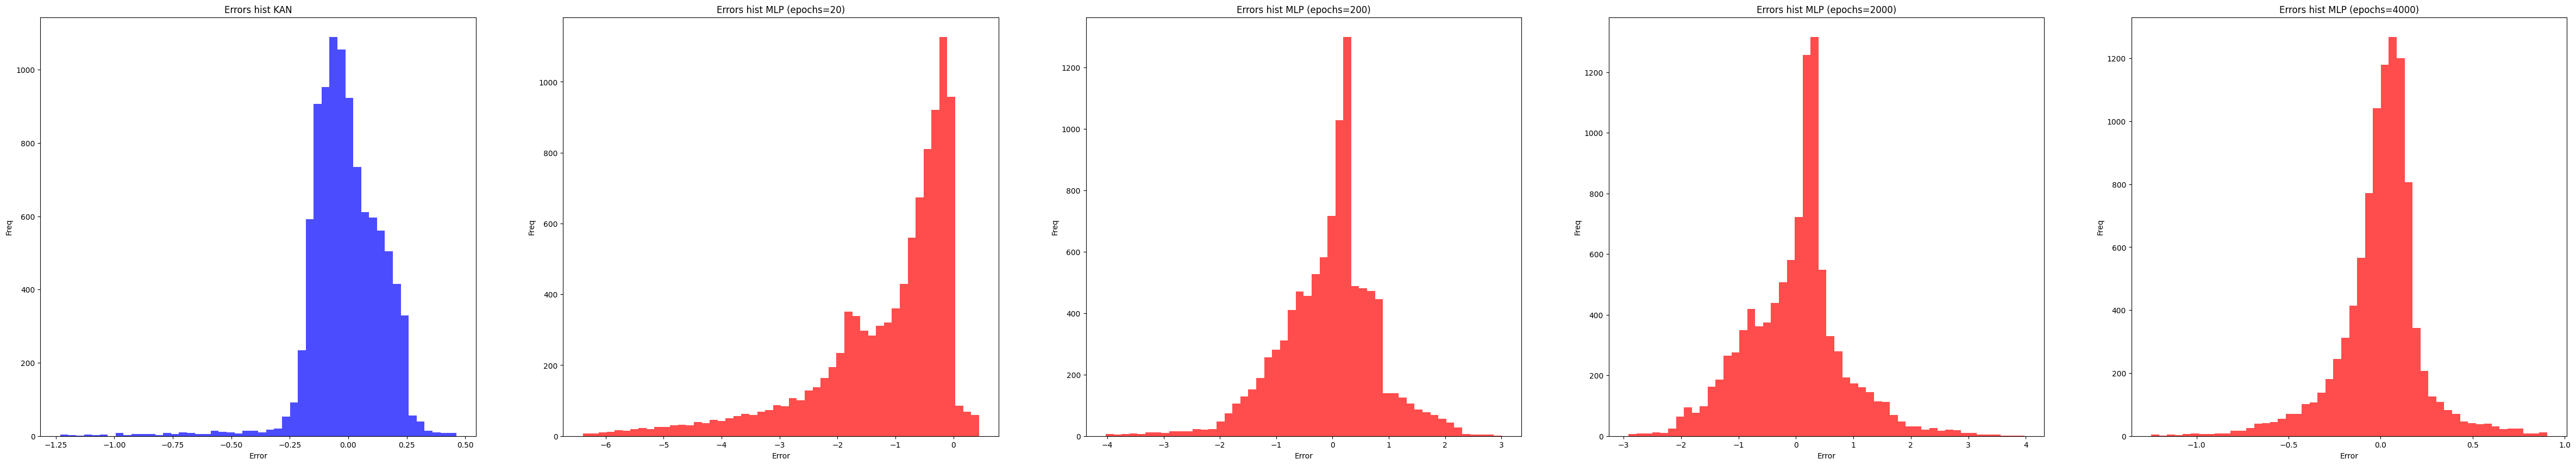

In [18]:
kan_errors = (kan_predictions - true_values).ravel()

mlp_errors_list = []
for mlp_model in mlp_models:
    mlp_predictions = mlp_model(xy).reshape(100, 100).detach().numpy()
    mlp_errors = (mlp_predictions - true_values).ravel()
    mlp_errors_list.append(mlp_errors)

fig, axs = plt.subplots(1, len(epochs_list) + 1, figsize=(12*(len(epochs_list) + 1), 10))

axs[0].hist(kan_errors, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Errors hist KAN')
axs[0].set_xlabel('Error')
axs[0].set_ylabel('Freq')

for i, mlp_errors in enumerate(mlp_errors_list):
    axs[i+1].hist(mlp_errors, bins=50, color='red', alpha=0.7)
    axs[i+1].set_title(f'Errors hist MLP (epochs={epochs_list[i]})')
    axs[i+1].set_xlabel('Error')
    axs[i+1].set_ylabel('Freq')

plt.show()


## Another experiment

In [19]:
test_dataset = create_dataset(f, n_var=2)
test_dataset['test_input'] = test_dataset['test_input'].float()
test_dataset['test_label'] = test_dataset['test_label'].float()

### Evaluate RMSE

KAN Model:
RMSE on test set: 0.13386451925632986

MLP Models:
RMSE on test set (MLP, epochs=20): 1.6217589378356934
RMSE on test set (MLP, epochs=200): 0.8194907307624817
RMSE on test set (MLP, epochs=2000): 0.8294389247894287
RMSE on test set (MLP, epochs=4000): 0.21120208501815796


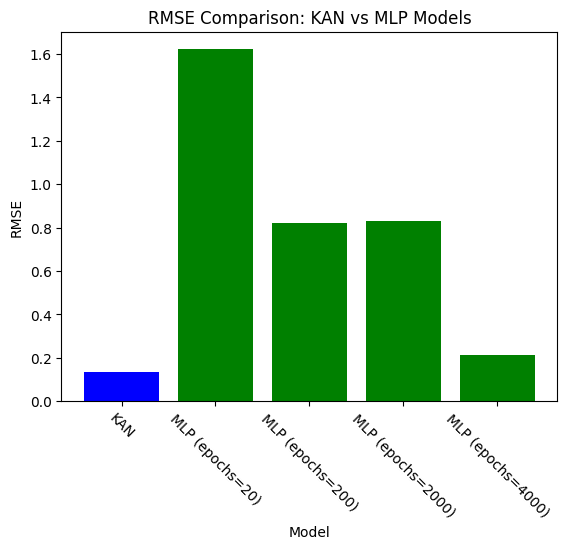

In [20]:
kan_rmse = evaluate_model(kan_model, test_dataset)[1]

mlp_rmse_list = []
for mlp_model in mlp_models:
    mlp_rmse = evaluate_model(mlp_model, test_dataset)[1]
    mlp_rmse_list.append(mlp_rmse)

print("KAN Model:")
print("RMSE on test set:", kan_rmse)

print("\nMLP Models:")
for i, mlp_rmse in enumerate(mlp_rmse_list):
    print(f"RMSE on test set (MLP, epochs={epochs_list[i]}):", mlp_rmse)

models = ['KAN'] + [f'MLP (epochs={epochs_list[i]})' for i in range(len(epochs_list))]
rmse_values = [kan_rmse] + mlp_rmse_list

plt.bar(models, rmse_values, color=['blue'] + ['green'] * len(epochs_list))
plt.title('RMSE Comparison: KAN vs MLP Models')
plt.xlabel('Model')
plt.xticks(rotation=-45)
plt.ylabel('RMSE')
plt.show()


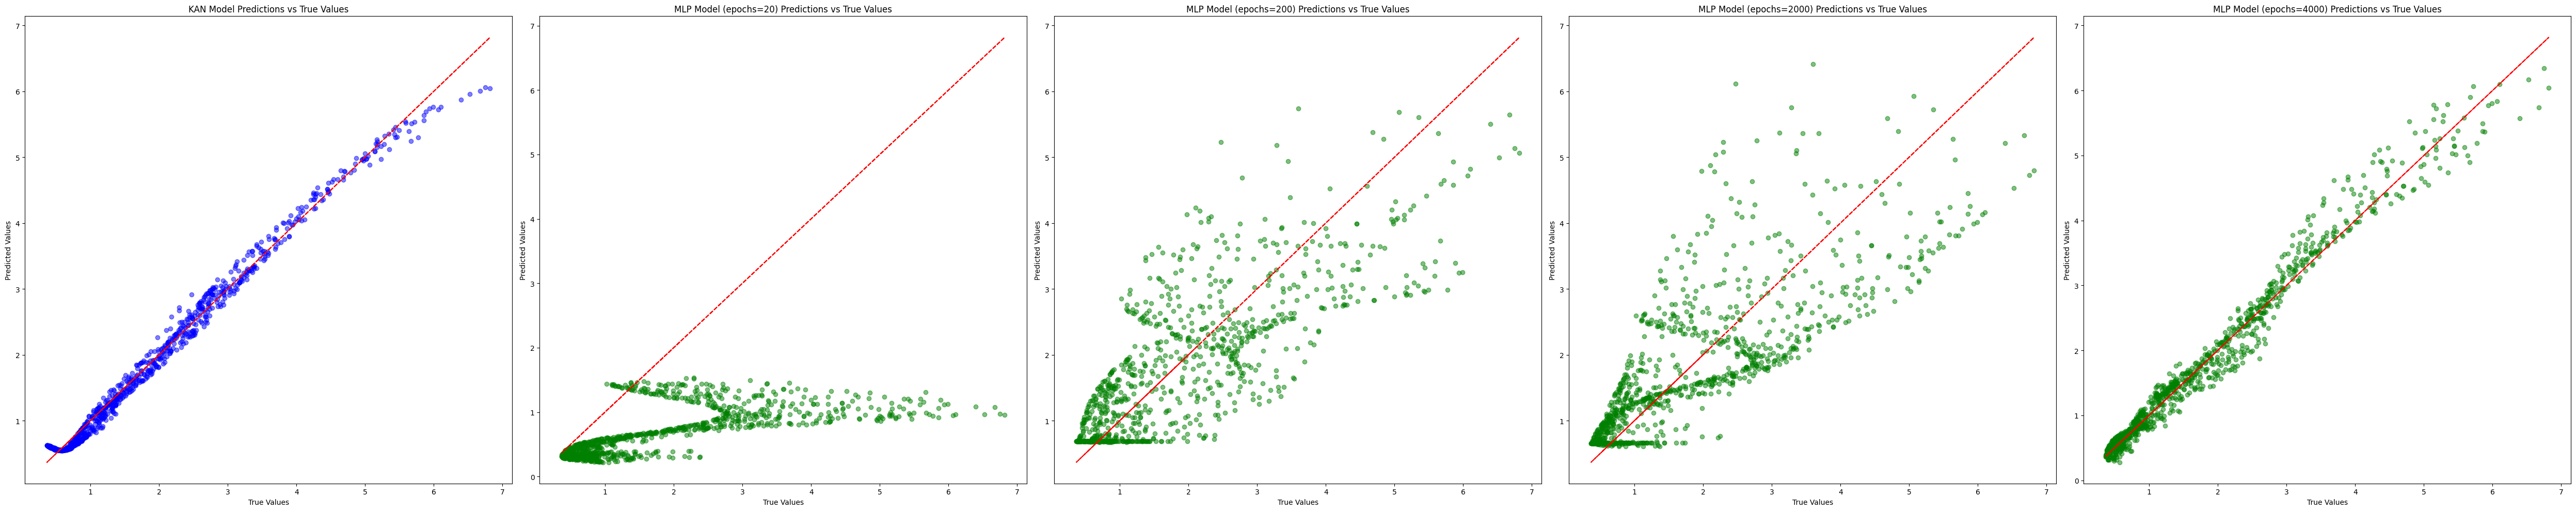

In [21]:
fig, axs = plt.subplots(1, len(epochs_list) + 1, figsize=(10 * (len(epochs_list) + 1), 10))

kan_test_predictions = kan_model(test_dataset['test_input']).detach().numpy()
axs[0].scatter(test_dataset['test_label'], kan_test_predictions, color='blue', alpha=0.5)
axs[0].plot(test_dataset['test_label'], test_dataset['test_label'], color='red', linestyle='--')
axs[0].set_title('KAN Model Predictions vs True Values')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')

for i, mlp_model in enumerate(mlp_models):
    mlp_test_predictions = mlp_model(test_dataset['test_input']).detach().numpy()
    axs[i+1].scatter(test_dataset['test_label'], mlp_test_predictions, color='green', alpha=0.5)
    axs[i+1].plot(test_dataset['test_label'], test_dataset['test_label'], color='red', linestyle='--')
    axs[i+1].set_title(f'MLP Model (epochs={epochs_list[i]}) Predictions vs True Values')
    axs[i+1].set_xlabel('True Values')
    axs[i+1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

Nuff said

## Lets test some real data

In [3]:
!wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/winequality-red.csv

--2024-05-02 10:18:15--  https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/winequality-red.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [text/plain]
Saving to: ‘winequality-red.csv.1’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.02s   

2024-05-02 10:18:15 (3.86 MB/s) - ‘winequality-red.csv.1’ saved [84199/84199]



In [4]:
# Load data
data = pd.read_csv('winequality-red.csv', delimiter=';')

### Normalize features

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(data.drop('quality', axis=1))
y = data['quality'].values

In [64]:
data['quality'].describe()

count    1599.000000
mean        5.636023
std         0.807569
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         8.000000
Name: quality, dtype: float64

### Split data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create models

#### Create and train MLP

In [7]:
mlp = nn.Sequential(
                    nn.Linear(X_train.shape[1], 64),
                    nn.ReLU(),
                    nn.Linear(64, 64),
                    nn.ReLU(),
                    nn.Linear(64, 1))

In [86]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)

    model = model.float()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    rmse_values = []


    pbar = tqdm(range(epochs), desc='Training', unit='epoch')
    for epoch in pbar:
        def closure():
            optimizer.zero_grad()
            outputs = model(X_train).squeeze()
            loss = criterion(outputs, y_train)
            loss.backward()
            return loss

        loss = optimizer.step(closure)

        with torch.no_grad():
            test_outputs = model(X_test).squeeze()
            test_loss = criterion(test_outputs, y_test)
            rmse = torch.sqrt(test_loss).item()
            rmse_values.append(rmse)

        pbar.set_description(f'Epoch {epoch+1}/{epochs} | RMSE: {rmse:.4f}')

    return model, rmse_values

In [71]:
mlp_model, rmses = train_model(mlp, X_train, y_train, X_test, y_test, epochs=100)

Epoch 100/100 | RMSE: 0.5889: 100%|██████████| 100/100 [00:01<00:00, 65.24epoch/s]


#### Create and train KAN

In [28]:
def train_kan(kan_model, X_train, y_train, epochs=20):
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    optimizer = optim.LBFGS(kan_model.parameters(), lr=1)

    def closure():
        optimizer.zero_grad()
        outputs = kan_model(X_train_t)
        loss = torch.mean((outputs.squeeze() - y_train_t) ** 2)
        loss.backward()
        return loss

    pbar = tqdm(range(epochs))
    for epoch in pbar:
        optimizer.step(closure)
        current_loss = closure().item()
        current_rmse = torch.sqrt(torch.tensor(current_loss))  # Calculate RMSE
        pbar.set_description(f'Epoch {epoch+1} | RMSE: {current_rmse:.4f}')
    return kan_model

In [41]:
kan_model = KAN(width=[11, 64, 1], grid=5, k=3, seed=0)
train_kan(kan_model, X_train, y_train)

Epoch 20 | RMSE: 0.0009: 100%|██████████| 20/20 [06:36<00:00, 19.81s/it]


KAN(
  (biases): ModuleList(
    (0): Linear(in_features=64, out_features=1, bias=False)
    (1): Linear(in_features=1, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

In [27]:
def evaluate_kan(model, X_test, y_test):
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    with torch.no_grad():
        predictions = model(X_test).squeeze()
    mse = torch.mean((predictions - y_test) ** 2)
    rmse = torch.sqrt(mse)

    return rmse.item()

In [43]:
kan_model.prune()
rmse_score = evaluate_kan(kan_model, X_test, y_test)
print(f"RMSE on test dataset: {rmse_score:.4f}")

RMSE on test dataset: 0.7357


In [ ]:
kan_model2 = KAN(width=[11, 16, 1], grid=5, k=3, seed=0)
train_kan(kan_model2, X_train, y_train)
kan_model2.prune()

In [16]:
rmse_score = evaluate_kan(kan_model2, X_test, y_test)
print(f"Hidden dim: 16. RMSE on test dataset: {rmse_score:.4f}")

Hidden dim: 16. RMSE on test dataset: 0.9218



  0%|          | 0/20 [00:00<?, ?it/s]
Epoch 1 | RMSE: 0.5787:   0%|          | 0/20 [00:02<?, ?it/s]
Epoch 1 | RMSE: 0.5787:   5%|▌         | 1/20 [00:02<00:53,  2.81s/it]
Epoch 2 | RMSE: 0.4201:   5%|▌         | 1/20 [00:05<00:53,  2.81s/it]
Epoch 2 | RMSE: 0.4201:  10%|█         | 2/20 [00:05<00:51,  2.85s/it]
Epoch 3 | RMSE: 0.3155:  10%|█         | 2/20 [00:08<00:51,  2.85s/it]
Epoch 3 | RMSE: 0.3155:  15%|█▌        | 3/20 [00:08<00:46,  2.73s/it]
Epoch 4 | RMSE: 0.2530:  15%|█▌        | 3/20 [00:10<00:46,  2.73s/it]
Epoch 4 | RMSE: 0.2530:  20%|██        | 4/20 [00:10<00:42,  2.67s/it]
Epoch 5 | RMSE: 0.2138:  20%|██        | 4/20 [00:13<00:42,  2.67s/it]
Epoch 5 | RMSE: 0.2138:  25%|██▌       | 5/20 [00:13<00:39,  2.65s/it]
Epoch 6 | RMSE: 0.1832:  25%|██▌       | 5/20 [00:17<00:39,  2.65s/it]
Epoch 6 | RMSE: 0.1832:  30%|███       | 6/20 [00:17<00:41,  2.98s/it]
Epoch 7 | RMSE: 0.1640:  30%|███       | 6/20 [00:19<00:41,  2.98s/it]
Epoch 7 | RMSE: 0.1640:  35%|███▌      | 7/20

Hidden dim: 16. RMSE on test dataset: 0.9426


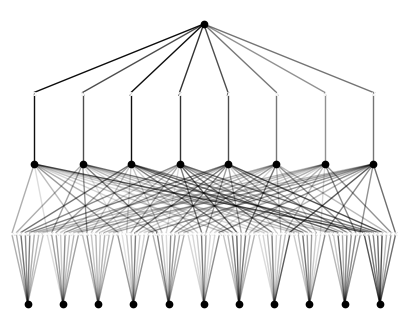

In [29]:
kan_model3 = KAN(width=[11, 8, 1], grid=5, k=3, seed=0)
train_kan(kan_model3, X_train, y_train)
kan_model3.prune()
kan_model3.plot()
rmse_score3 = evaluate_kan(kan_model3, X_test, y_test)
print(f"Hidden dim: 8. RMSE on test dataset: {rmse_score3:.4f}")

Epoch 6 | RMSE: 0.3704: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Hidden dim: 4. 6 epochs. RMSE on test dataset: 0.9426


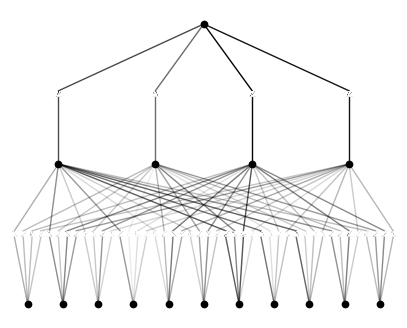

In [30]:
kan_model4 = KAN(width=[11, 4, 1], grid=5, k=3, seed=0)
train_kan(kan_model4, X_train, y_train, epochs=6)
kan_model4.prune()
kan_model4.plot()
rmse_score4 = evaluate_kan(kan_model4, X_test, y_test)
print(f"Hidden dim: 4. 6 epochs. RMSE on test dataset: {rmse_score3:.4f}")

Epoch 1 | RMSE: 0.6107: 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Hidden dim: 2. RMSE on test dataset: 0.6253


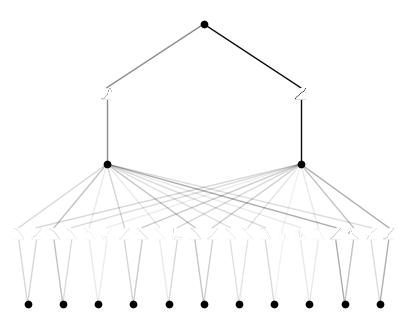

In [57]:
kan_model5 = KAN(width=[11, 2, 1], grid=5, k=3, seed=0)
train_kan(kan_model5, X_train, y_train, epochs=1)
kan_model5.prune()
kan_model5.plot()
rmse_score5 = evaluate_kan(kan_model5, X_test, y_test)
print(f"Hidden dim: 2. RMSE on test dataset: {rmse_score5:.4f}")

## Evaluating

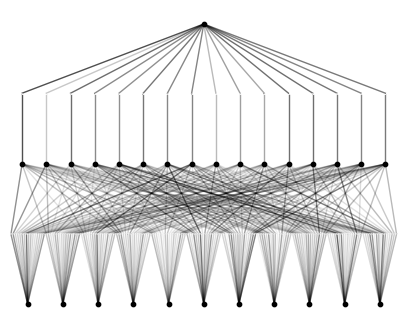

In [17]:
kan_model2.plot(mask=True)

In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    with torch.no_grad():
        # Training data
        train_preds = model(torch.FloatTensor(X_train)).squeeze()
        train_rmse = torch.sqrt(torch.mean((train_preds - torch.FloatTensor(y_train)) ** 2))

        # Test data
        test_preds = model(torch.FloatTensor(X_test)).squeeze()
        test_rmse = torch.sqrt(torch.mean((test_preds - torch.FloatTensor(y_test)) ** 2))

    return train_rmse.item(), test_rmse.item()


In [54]:
mlp_train_rmse, mlp_test_rmse = evaluate_model(mlp_model, X_train, y_train, X_test, y_test)
kan_train_rmse, kan_test_rmse = evaluate_model(kan_model, X_train, y_train, X_test, y_test)
kan_train_rmse2, kan_test_rmse2 = evaluate_model(kan_model2, X_train, y_train, X_test, y_test)
kan_train_rmse3, kan_test_rmse3 = evaluate_model(kan_model3, X_train, y_train, X_test, y_test)
kan_train_rmse4, kan_test_rmse4 = evaluate_model(kan_model4, X_train, y_train, X_test, y_test)
kan_train_rmse5, kan_test_rmse5 = evaluate_model(kan_model5, X_train, y_train, X_test, y_test)

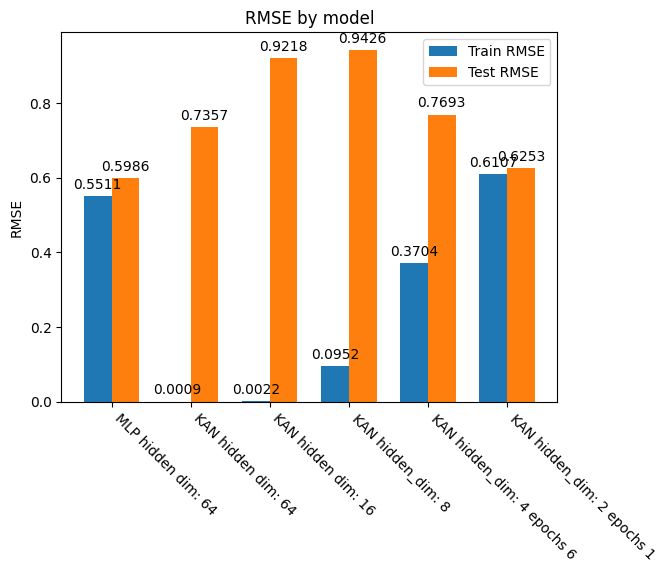

In [60]:
labels = ['MLP hidden dim: 64', 'KAN hidden dim: 64', 'KAN hidden dim: 16', 'KAN hidden_dim: 8', 'KAN hidden_dim: 4 epochs 6', 'KAN hidden_dim: 2 epochs 1']
train_rmses = [mlp_train_rmse, kan_train_rmse,kan_train_rmse2, kan_train_rmse3, kan_train_rmse4,kan_train_rmse5]
test_rmses = [mlp_test_rmse, kan_test_rmse,kan_test_rmse2, kan_test_rmse3, kan_test_rmse4, kan_test_rmse5]

x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x, train_rmses, width, label='Train RMSE')
rects2 = ax.bar([p + width for p in x], test_rmses, width, label='Test RMSE')

ax.set_ylabel('RMSE')
ax.set_title('RMSE by model')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels, rotation=-45, horizontalalignment='left')
ax.legend()

ax.bar_label(rects1, fmt='%.4f', padding=3)
ax.bar_label(rects2, fmt='%.4f', padding=3)

plt.show()



## Air quality dataset

In [49]:
df = pd.read_csv('AirQuality.csv', sep=';', decimal=",",header=0)

### Some EDA

In [50]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [51]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,NaN,NaN
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,NaN,NaN
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,NaN,NaN
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,NaN,NaN
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,NaN,NaN


In [52]:
df.isnull().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


In [54]:
df1 = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)
df1= df1.dropna()

In [59]:
df2 = df1.replace(to_replace=-200,value=np.nan) # as of description
df2 = df2.drop(columns=['NMHC(GT)'])
col = ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)','PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)','PT08.S5(O3)', 'T', 'RH', 'AH']
df2 = df2[col]

<Axes: >

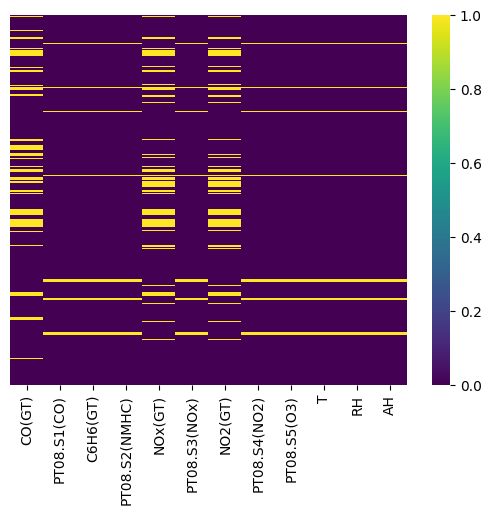

In [60]:
sns.heatmap(df2.isna(),yticklabels=False, cmap='viridis')

In [61]:
for col in df2.columns:
    df2[col] = df2[col].fillna(df2[col].mean())

In [64]:
df3 = df2.copy()
Q1 = df3.quantile(0.25)
Q3 = df3.quantile(0.75)
IQR = Q3 - Q1
outliers = (df3 < (Q1 - 1.5 * IQR)) | (df3 > (Q3 + 1.5 * IQR))

for val in outliers.columns:
    df3[val].astype('float')
    temp = df3[val].median()
    df3.loc[outliers[val], val] = temp


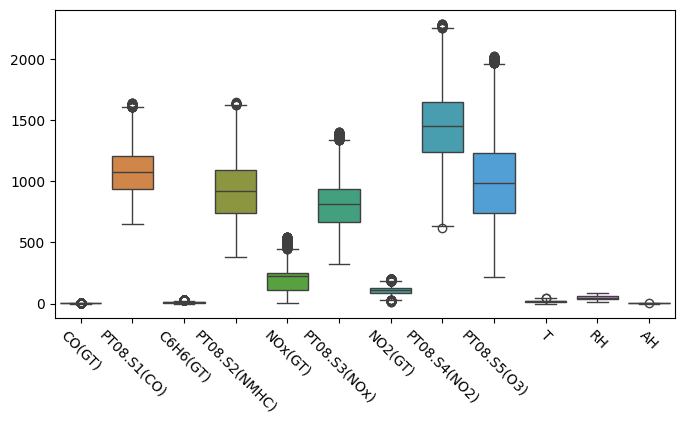

In [69]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df3)

plt.xticks(rotation=-45)

plt.show()

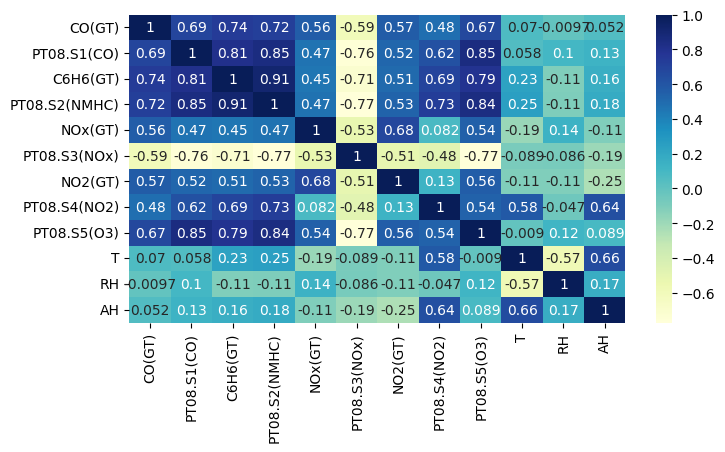

In [72]:
plt.figure(figsize=(8,4))
sns.heatmap(df3.corr(),cmap='YlGnBu', annot=True)
plt.show()

### Preprare for training

In [81]:
X = df3[['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)','PT08.S5(O3)']]
y = df3['C6H6(GT)']
y = y.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [82]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### Get models

In [94]:
def train_model(model, X_train, y_train, X_test, y_test, epochs=100):
    X_train = torch.FloatTensor(X_train)
    y_train = torch.FloatTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.FloatTensor(y_test)

    model = model.float()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    rmse_values = []
    r2_scores = []

    pbar = tqdm(range(epochs), desc='Training', unit='epoch')
    for epoch in pbar:
        def closure():
            optimizer.zero_grad()
            outputs = model(X_train).squeeze()
            loss = criterion(outputs, y_train)
            loss.backward()
            return loss

        loss = optimizer.step(closure)

        with torch.no_grad():
            test_outputs = model(X_test).squeeze()
            test_loss = criterion(test_outputs, y_test)
            rmse = torch.sqrt(test_loss).item()
            rmse_values.append(rmse)
            r2 = r2_score(y_test, test_outputs.numpy())
            r2_scores.append(r2)

        pbar.set_description(f'Epoch {epoch+1}/{epochs} | RMSE: {rmse:.4f} | R²: {r2:.4f}')

    return model, rmse_values, r2_scores

In [148]:
mlp = lambda: nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

mlp_model200, rmses200, r_twos200 = train_model(mlp(), X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200)
mlp_model500, rmses500, r_twos500 = train_model(mlp(), X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=500)
mlp_model2k, rmses2k, r_twos2k = train_model(mlp(), X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=2000)


Epoch 200/200 | RMSE: 1.5258 | R²: 0.9329: 100%|██████████| 200/200 [00:02<00:00, 67.74epoch/s]
Epoch 500/500 | RMSE: 0.7462 | R²: 0.9840: 100%|██████████| 500/500 [00:08<00:00, 60.81epoch/s]
Epoch 2000/2000 | RMSE: 0.5536 | R²: 0.9912: 100%|██████████| 2000/2000 [00:40<00:00, 49.36epoch/s]


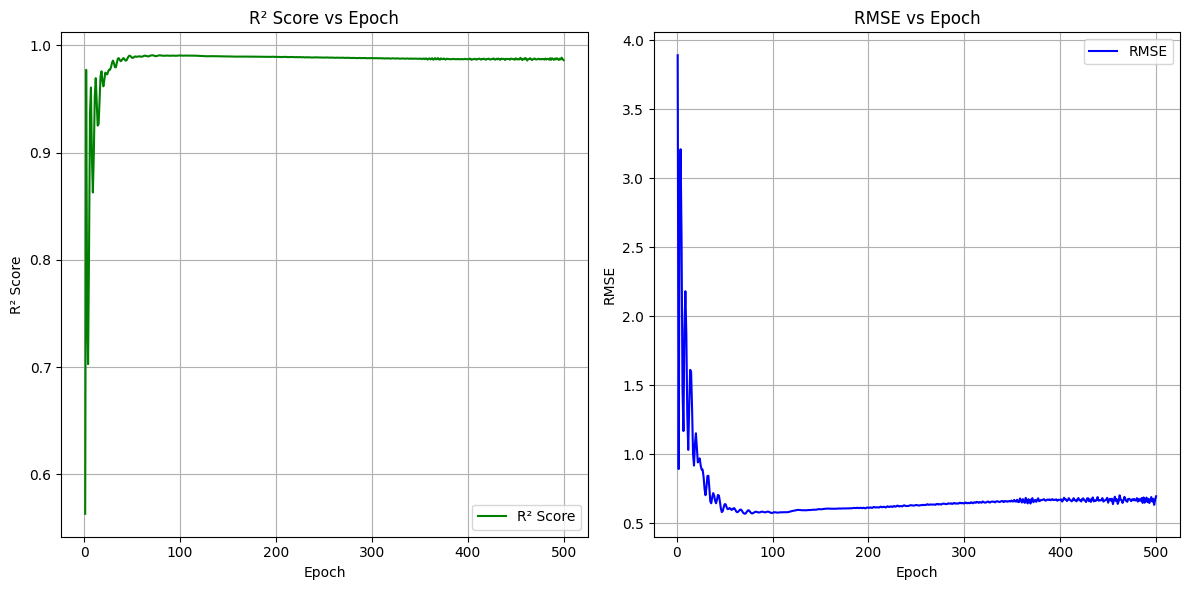

In [104]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(r_twos500)+1), r_twos500, label='R² Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('R² Score vs Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(rmses500)+1), rmses500, label='RMSE', color='blue')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE vs Epoch')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

### KANs

In [169]:
def train_kan_sizes(X_train, y_train, X_test, y_test, sizes, epochs_per_size):
    X_train = X_train.double()
    y_train = y_train.double()
    X_test = X_test.double()
    y_test = y_test.double()
    results = []
    trained_models = []
    for size in sizes:
        epochs = epochs_per_size.get(size, 2)  # Default to 2 epochs
        kan_model = KAN(width=[X_train.shape[1], size, 1], grid=5, k=3, seed=0)
        optimizer = optim.LBFGS(kan_model.parameters(), lr=1)
        criterion = nn.MSELoss()


        pbar = tqdm(range(epochs), desc=f'Training model with size {size}', unit='epoch')
        for epoch in pbar:
            def closure():
                optimizer.zero_grad()
                outputs = kan_model(X_train).squeeze()
                if torch.isnan(outputs).any():
                    print(f"NaNs detected in model outputs during training with size {size}")
                loss = criterion(outputs, y_train)
                loss.backward()
                return loss

            optimizer.step(closure)
            pbar.set_description(f'Model size: {size} | Epoch {epoch+1}/{epochs}')

        kan_model.prune()
        with torch.no_grad():
            outputs = kan_model(X_test).squeeze()
            if torch.isnan(outputs).any():
                print(f"NaNs detected in model outputs during testing with size {size}")
            mse = criterion(outputs, y_test)
            rmse = torch.sqrt(mse).item()
            r2 = r2_score(y_test.numpy(), outputs.numpy())

        results.append((size, rmse, r2))

        trained_models.append(kan_model)

    return trained_models, results


In [170]:
sizes = [16, 8, 5, 2]
epochs = [2, 3, 4, 5]
epochs_per_size = {size: epoch for size, epoch in zip(sizes, epochs)}

models, results = train_kan_sizes(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, sizes, epochs_per_size)

Model size: 16 | Epoch 2/2: 100%|██████████| 2/2 [01:18<00:00, 39.23s/epoch]
Model size: 8 | Epoch 3/3: 100%|██████████| 3/3 [00:38<00:00, 12.81s/epoch]
Model size: 5 | Epoch 4/4: 100%|██████████| 4/4 [00:18<00:00,  4.63s/epoch]
Model size: 2 | Epoch 5/5: 100%|██████████| 5/5 [00:10<00:00,  2.10s/epoch]


### Compare data

<ipython-input-173-92885a71d8ea>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(labels_mlp, rotation=45)
<ipython-input-173-92885a71d8ea>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(labels_mlp, rotation=45)


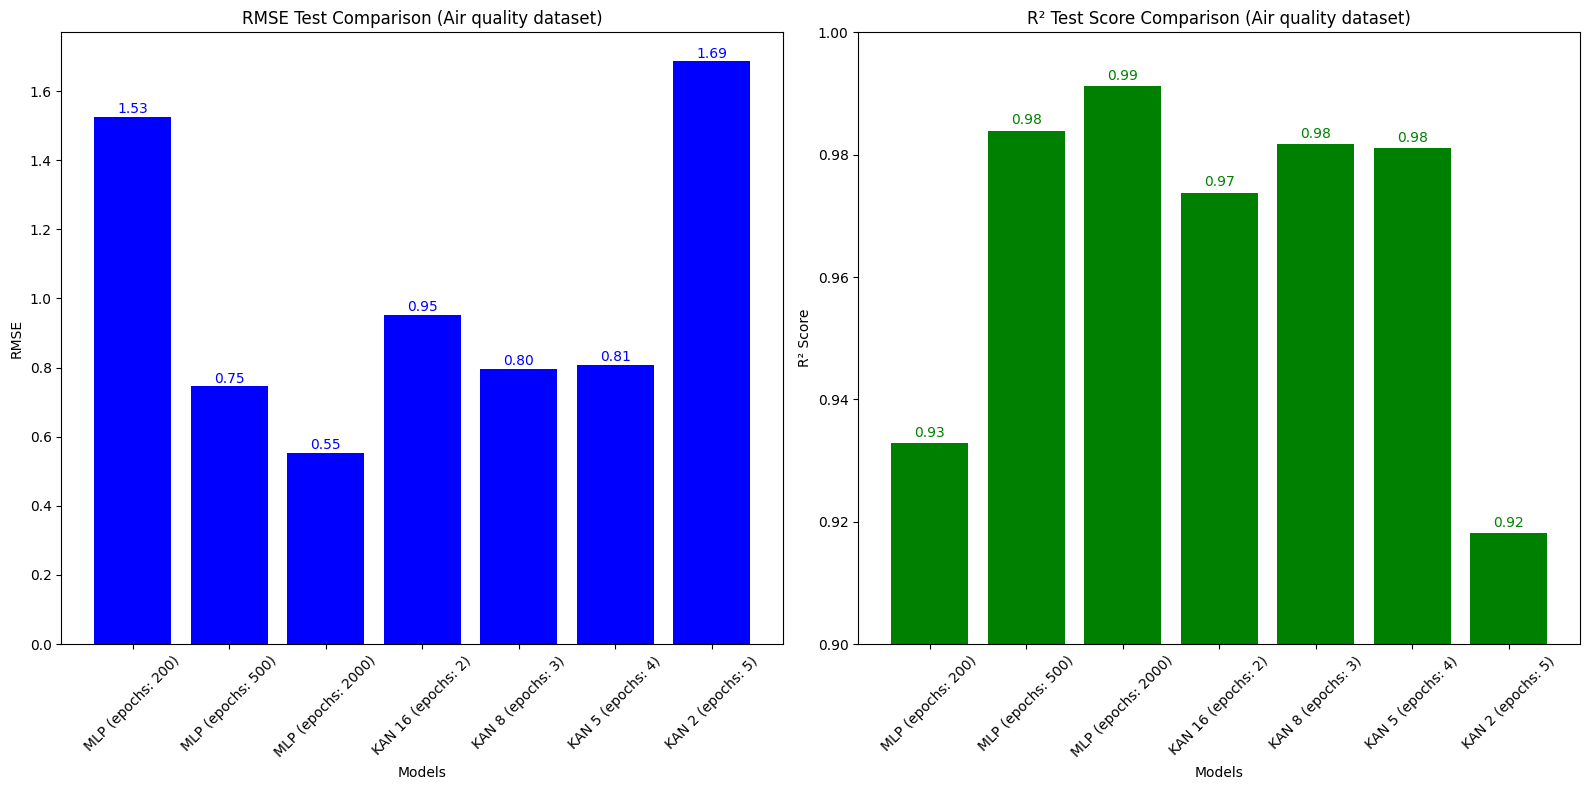

In [173]:
sizes, kan_rmses, kan_r2s = zip(*results)
labels_mlp = ['MLP (epochs: 200)', 'MLP (epochs: 500)', 'MLP (epochs: 2000)'] + [f'KAN {size} (epochs: {epochs_per_size[size]})' for size in sizes]
rmses_mlp = [rmses200[-1], rmses500[-1], rmses2k[-1]] + list(kan_rmses)
r2s_mlp = [r_twos200[-1], r_twos500[-1], r_twos2k[-1]] + list(kan_r2s)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].bar(labels_mlp, rmses_mlp, color='blue')
axs[0].set_title('RMSE Test Comparison (Air quality dataset)')
axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Models')
axs[0].set_xticklabels(labels_mlp, rotation=45)
for i, v in enumerate(rmses_mlp):
    axs[0].text(i, v + 0.01, f"{v:.2f}", ha='center', color='blue')

axs[1].bar(labels_mlp, r2s_mlp, color='green')
axs[1].set_title('R² Test Score Comparison (Air quality dataset)')
axs[1].set_ylabel('R² Score')
axs[1].set_xlabel('Models')
axs[1].set_xticklabels(labels_mlp, rotation=45)
axs[1].set_ylim(0.9, 1.0)
for i, v in enumerate(r2s_mlp):
    axs[1].text(i, v + 0.001, f"{v:.2f}", ha='center', color='green')

plt.tight_layout()
plt.show()
